Aaron FARGEON  
Julien KHLAUT  
Pierre-Louis RUHLMANN

# PROJECT 3 : PERFORMANCE OF THE LASSO IN HIGH-DEMENSIONAL LINEAR REGRESSION

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import linear_model
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib

We consider a linear model where one observes iid observations $$y_i = x_i^T \beta^* + \varepsilon_i$$ where $x_i$ has iid $\mathcal{N}(0,1)$ entries and $\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$. The goal is to study the performance of the Lasso

\begin{equation}
    \tag{L}
    \hat{\beta} = \underset{b \in \mathbb{R}^p}{\text{argmin}} \frac{1}{n} \sum\limits_{i=1}^n \frac{(y_i - x_i^T b)^2}{2} + n^{-\frac{1}{2}} \lambda \vert \vert b \vert \vert_1
\end{equation}

where $\lambda > 0$ is a tuning parameter.

We focus on the situation where if $p, n$ are high but of the same order, i.e. $\frac{n}{p} = \delta$ (or $\frac{p}{n} \rightarrow \delta$) for some constant $\delta > 0$ independent of $n,p$. We will also assume that for each $n,p$, the true $\beta^*$ is such that $\beta^*_j = \frac{\Theta_j}{\sqrt{p}}$ where $\Theta_1,...,\Theta_p$ are iid random variables of the form $\Theta_j=r_j B_j$ where $Bj$ has the Bernoulli distribution with parameter 0.128 and $r_j \in \{\pm1\}$ is a random sign independent of $B_j$ with $\mathbb{E}[r_j] = 0$. The true parameter $\beta^*$ is thus “sparse” in the sense that, approximately, only 12.8 percent of coordinates are nonzero.

#### First task  
Set $\delta = 0.64$ and $\sigma^2 = 0.2$. For each tuning parameter $\lambda$ on a grid of equispaced points in $[0,2.5]$, compute 10 different datasets with $p= 400$, $n=p \delta$, design matrix $X$ with iid entries, $\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$, $\beta^* \in \mathbb{R}^p$ generated with iid components $\frac{\Theta_j}{\sqrt{p}}$ as  explained above, and for each dataset compute the  estimator $\hat{\beta}$ in $(\text{L})$ and report its performance $\vert \vert \hat{\beta} − \beta^* \vert \vert^2$ in boxplots where the $x$-axis represents $\lambda$ and the $y$-axis $\vert \vert \hat{\beta} − \beta^* \vert \vert^2$. You can for instance use seaborn’s boxplot. If your computer is sufficiently powerful, plot similar boxplots with $p = 600$ and/or $p= 800$ with always $n=p \delta$, $\delta= 0.64$.

In [5]:
def lasso(b, y, X, n, l):
    return np.mean((y - np.dot(X.T, b))**2 / 2) + (l * np.linalg.norm(b, ord = 1)) / np.sqrt(n)
    

In [8]:
delta = 0.64
sigma2 = 0.2

dataset_number = 10

grid = np.linspace(0, 2.5, 50)

p = 400
n = int(p * delta)

diff = np.zeros((len(grid), dataset_number))

for index, l in enumerate(tqdm(grid)):
    
    for k in range(dataset_number):
    
        X = np.random.normal(0, 1, size = (p,n))

        epsilon = np.random.normal(0, sigma2, size = n)

        beta_star = np.zeros(p)
        r = np.random.choice(np.array([-1,1]),size=p)
        B = np.random.binomial(1, 0.128, size=p)
        beta_star = (r * B) / np.sqrt(p)

        y = np.dot(X.T, beta_star) + epsilon

        beta_hat = opt.minimize(lasso, beta_star, args=(y, X, n, l)).x
        
        diff[index, k] = np.linalg.norm(beta_hat - beta_star) ** 2

Text(0, 0.5, '$ || \\hat{\\beta} - \\beta^* ||$')

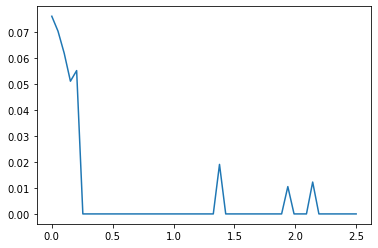

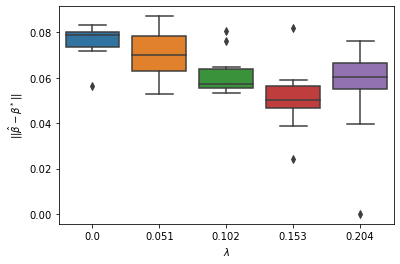

In [9]:
plt.figure()
plt.plot(grid, np.mean(diff, axis=1))
plt.figure()
grid_for_boxplot = np.repeat(grid[:5], dataset_number)
diff2 = diff[:5,:]
diff_for_boxplot = diff2.flatten()
ax = sns.boxplot(grid_for_boxplot, diff_for_boxplot)
ax.set_xticks(np.arange(0,5))
ax.set_xticklabels(np.around(grid[np.arange(0,5)], 3))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$ || \hat{\beta} - \beta^* ||$')

In [10]:
delta = 0.64
sigma2 = 0.2

dataset_number = 50

grid = np.linspace(0.01, 2.5, 100)

p = 400
n = int(p * delta)

diff = np.zeros((len(grid), dataset_number))

for index, l in enumerate(tqdm(grid)):
    
    for k in range(dataset_number):
    
        X = np.random.normal(0, 1, size = (p,n))

        epsilon = np.random.normal(0, sigma2, size = n)

        beta_star = np.zeros(p)
        r = np.random.choice(np.array([-1,1]),size=p)
        B = np.random.binomial(1, 0.128, size=p)
        beta_star = (r * B) / np.sqrt(p)

        y = np.dot(X.T, beta_star) + epsilon

        las = linear_model.Lasso(alpha = l, fit_intercept = False)
        las.fit(X.T, y)
        diff[index, k] = np.linalg.norm(las.coef_ - beta_star) ** 2

Text(0, 0.5, '$ || \\hat{\\beta} - \\beta^* ||$')

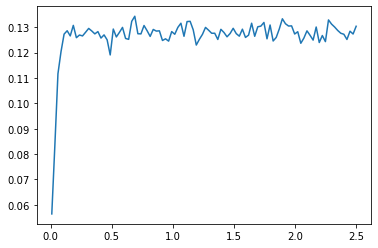

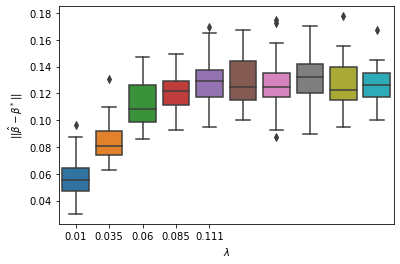

In [11]:
plt.figure()
plt.plot(grid, np.mean(diff, axis=1))
plt.figure()
grid_for_boxplot = np.repeat(grid[:10], dataset_number)
diff_for_boxplot = diff[:10,:].flatten()
ax = sns.boxplot(grid_for_boxplot, diff_for_boxplot)
ax.set_xticks(np.arange(0,5))
ax.set_xticklabels(np.around(grid[np.arange(0,5)], 3))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$ || \hat{\beta} - \beta^* ||$')

In [40]:
delta = 0.8
p = 400
n = int(p * delta)

beta_star = np.hstack([np.ones(26), -np.ones(25), np.zeros(p-51)]) / np.sqrt(p)
assert beta_star.shape == (p, )

n_datasets = 100

data1 = []
for _ in range(n_datasets):
    X = np.random.normal(size=(n, p))
    y = X@beta_star + np.sqrt(0.4) * np.random.normal(size=(n, ))
    result = linear_model.Lasso.path(X=X, y=y, fit_intercept=False, l1_ratio=1.0, alphas=n**(-0.5) * np.linspace(0.05, 2.5, num=50))
    lambdas = np.around(result[0] * np.sqrt(n), decimals = 2)
    coefs = result[1]
    for i, lam in enumerate(lambdas):
        hat_beta = coefs[:, i]
        mse = np.linalg.norm(hat_beta - beta_star)**2
        data1.append({'lambda': lam, 'MSE': mse})

In [41]:
df = pd.DataFrame(data1)
lambda_from_df = list(np.unique(sorted(list(df["lambda"]))))
npdf = np.asarray(df)
rng = range(npdf.shape[0])
mse_from_df1 = []
for l in lambda_from_df:
    N = np.array([npdf[i,1] for i in rng if npdf[i,0] == l])
    mse_from_df1.append(N.mean())

In [42]:
delta = 0.4
p = 400
n = int(p * delta)

beta_star = np.hstack([np.ones(26), -np.ones(25), np.zeros(p-51)]) / np.sqrt(p)
assert beta_star.shape == (p, )

n_datasets = 100

data2 = []
for _ in range(n_datasets):
    X = np.random.normal(size=(n, p))
    y = X@beta_star + np.sqrt(0.5) * np.random.normal(size=(n, ))
    result = linear_model.Lasso.path(X=X, y=y, fit_intercept=False, l1_ratio=1.0, alphas=n**(-0.5) * np.linspace(0.05, 2.5, num=50))
    lambdas = np.around(result[0] * np.sqrt(n), decimals = 2)
    coefs = result[1]
    for i, lam in enumerate(lambdas):
        hat_beta = coefs[:, i]
        mse = np.linalg.norm(hat_beta - beta_star)**2
        data2.append({'lambda': lam, 'MSE': mse})

In [43]:
df = pd.DataFrame(data2)
lambda_from_df = list(np.unique(sorted(list(df["lambda"]))))
npdf = np.asarray(df)
rng = range(npdf.shape[0])
mse_from_df2 = []
for l in lambda_from_df:
    N = np.array([npdf[i,1] for i in rng if npdf[i,0] == l])
    mse_from_df2.append(N.mean())

In [50]:
delta = 0.3
p = 400
n = int(p * delta)

beta_star = np.hstack([np.ones(26), -np.ones(25), np.zeros(p-51)]) / np.sqrt(p)
assert beta_star.shape == (p, )

n_datasets = 100

data3 = []
for _ in range(n_datasets):
    X = np.random.normal(size=(n, p))
    y = X@beta_star + np.sqrt(0.1) * np.random.normal(size=(n, ))
    result = linear_model.Lasso.path(X=X, y=y, fit_intercept=False, l1_ratio=1.0, alphas=n**(-0.5) * np.linspace(0.05, 2.5, num=50))
    lambdas = np.around(result[0] * np.sqrt(n), decimals = 2)
    coefs = result[1]
    for i, lam in enumerate(lambdas):
        hat_beta = coefs[:, i]
        mse = np.linalg.norm(hat_beta - beta_star)**2
        data3.append({'lambda': lam, 'MSE': mse})

In [51]:
df = pd.DataFrame(data3)
lambda_from_df = list(np.unique(sorted(list(df["lambda"]))))
npdf = np.asarray(df)
rng = range(npdf.shape[0])
mse_from_df3 = []
for l in lambda_from_df:
    N = np.array([npdf[i,1] for i in rng if npdf[i,0] == l])
    mse_from_df3.append(N.mean())

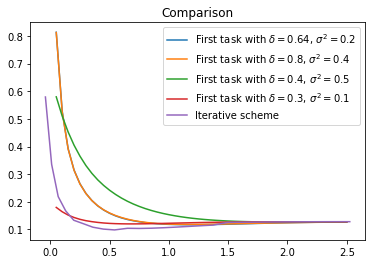

In [53]:
plt.plot(lambda_from_df, mse_from_df, label="First task with $\delta = 0.64$, $\sigma^2 = 0.2$")
plt.plot(lambda_from_df, mse_from_df1, label="First task with $\delta = 0.8$, $\sigma^2 = 0.4$")
plt.plot(lambda_from_df, mse_from_df2, label="First task with $\delta = 0.4$, $\sigma^2 = 0.5$")
plt.plot(lambda_from_df, mse_from_df3, label="First task with $\delta = 0.3$, $\sigma^2 = 0.1$")
plt.plot(Lambda, Tho_square, label="Iterative scheme")
plt.title("Comparison")
plt.legend()

#### Question 8  
Compare the previous iterative scheme $\tau_t = F_{\alpha, \delta} (\tau_{t-1})$ this with another idea to compute $\tau^*(\alpha)$, which consists, at each step t, of replacing the expectation in the right hand side of the system by averages over 100 000 independent copies of $(\Theta,Z)$. (Use 100 000 fresh independent copies at each iteration $t$). Do the two implementations coincide ? You may change the value 100 000 to a smaller/larger one depending on the power of your laptop.

In [13]:
def eta_prime(u,t):
    return (np.abs(u) - t > 0) * 1

def list_theta_Z(p=0.128,sigma2=0.2,test_size = 100000):
    rng = np.random.default_rng()
    theta = rng.binomial(0,p,size=test_size) * np.random.choice(np.array([-1, 1]),test_size)
    Z = rng.normal(0,sqrt(sigma2),size=test_size)
    return theta, Z

def compute_esp(tau, alpha, p=0.128, sigma2=0.2, test_size = 1000000):
    theta, Z = list_theta_Z(p,sigma2,test_size)
#     ETA = np.array([eta((theta + tau*Z)[i], tau*alpha) for i in range(test_size)])
    ETA = eta(theta + tau*Z, tau*alpha)
    esp1 = np.mean((ETA-theta)**2)
    #tau_star = sigma2 + esp1 / delta
#     ETA_PRIME = np.array([eta_prime((theta + tau*Z)[i], tau*alpha) for i in range(test_size)])
    ETA_PRIME = eta_prime(theta+tau*Z,tau*alpha)
    esp2 = np.mean(ETA_PRIME)
    #b_star = tau_star * (1 - esp2 / delta)
    return esp1, esp2

print(compute_esp(sqrt(0.2 + 1/(2*0.64)),1))

(0.0011420654655002976, 0.025539)


In [14]:
def F_new(alpha, delta, tho, sigma2):
    return sigma2 + compute_esp(tho, alpha, sigma2 = sigma2)[0] / delta

def compute_b_new(tho, delta, alpha):
    return tho*(1 - compute_esp(tho,alpha,sigma2=sigma2)[1] / delta)

def solve_implement_new(F, alpha, delta, tho_0, sigma2, eps):
    tho_1 = tho_0
    tho_2 = sqrt(F(alpha, delta, tho_0, sigma2))
    it = 0
    while abs(tho_1 - tho_2) > eps and it < 1000:
        tho_1 = tho_2
        tho_2 = sqrt(F(alpha, delta, tho_1, sigma2))
        it += 1
    return tho_1

tho_0 = sqrt(0.2 + 1/(2*0.64))
tau_new = solve_implement_new(F_new, 1, 0.64, tho_0, 0.2, 1e-1)
print("tau_new =", tau_new)
print("b_new = ", compute_b_new(tau,0.64,1))


tau_new = 0.44910682870550395
b_new =  0.7093542495684299


  0%|          | 0/30 [00:00<?, ?it/s]

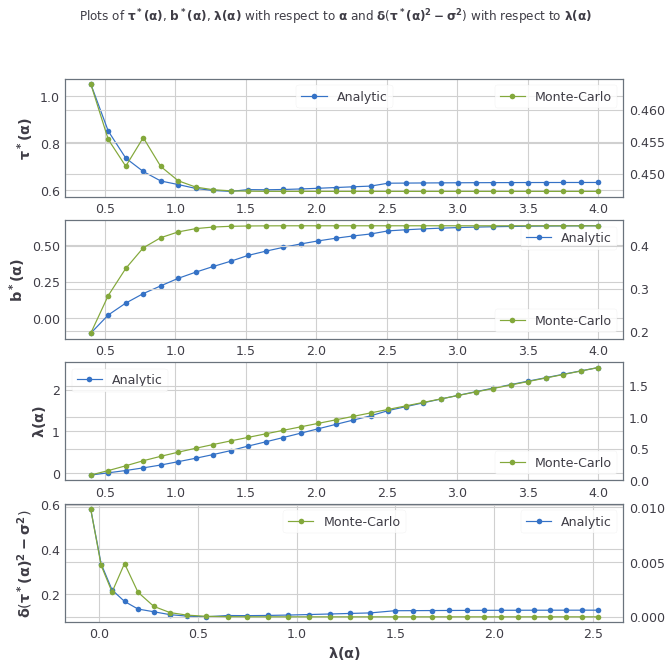

In [12]:
delta = 0.64
sigma2 = 0.2
alpha = np.linspace(0.4, 4, 30)
Tho = []
Tho_new = []
Tho_square = []
Tho_square_new = []
B = []
B_new = []
Lambda = []
Lambda_new = []

fig, axs = plt.subplots(4, 1, constrained_layout=False, figsize=(10, 10))

for a in tqdm(alpha):
    tho = solve_implement(F, a, delta, sqrt(sigma2 + 1/(2*delta)), sigma2, 1e-2)
    tho_new = solve_implement_new(F_new,a,delta,sqrt(sigma2 + 1/(2*delta)), sigma2, 1e-2)
    Tho.append(tho)
    Tho_new.append(tho_new)
    Tho_square.append(delta*(tho**2-sigma2))
    Tho_square_new.append(delta*(tho_new**2-sigma2))
    b = compute_b(tho, delta, a)
    b_new = compute_b_new(tho_new, delta, a)
    B.append(b)
    B_new.append(b_new)
    l = compute_lambda(b, a)
    l_new = compute_lambda(b_new, a)
    Lambda.append(l)
    Lambda_new.append(l_new)

fig.suptitle(r"Plots of $\mathbf{\tau^* (\alpha)}$, $\mathbf{b^* (\alpha)}$, $\mathbf{\lambda (\alpha)}$" \
                r" with respect to $\mathbf{\alpha}$ and $\mathbf{\delta\left( \tau^* (\alpha)^2 - \sigma^2 \right) }$"\
                r" with respect to $\mathbf{\lambda(\alpha)}$")
axs[0].plot(alpha, Tho,marker='o', label='Analytic')
ix = axs[0].twinx()
ix.plot(alpha, Tho_new, marker='o', label='Monte-Carlo', color='g')
axs[0].set_ylabel(r"$\mathbf{\tau^* (\alpha)}$")
axs[0].set_xlabel(r"$\mathbf{\alpha}$")
axs[0].legend(loc='upper center')
ix.legend()
axs[1].plot(alpha, B,marker='o', label='Analytic')
ix = axs[1].twinx()
ix.plot(alpha, B_new, marker='o', label='Monte-Carlo', color='g')
axs[1].set_xlabel(r"$\mathbf{\alpha}$")
axs[1].set_ylabel(r"$\mathbf{b^* (\alpha)}$")
axs[1].legend()
ix.legend(loc='lower right')
axs[2].plot(alpha, Lambda,marker='o', label='Analytic')
ix = axs[2].twinx()
ix.plot(alpha, Lambda_new, marker='o', label='Monte-Carlo', color='g')
axs[2].set_xlabel(r"$\mathbf{\alpha}$")
axs[2].set_ylabel(r"$\mathbf{\lambda (\alpha)}$")
axs[2].legend()
ix.legend(loc='lower right')
axs[3].plot(Lambda, (Tho_square),marker='o', label='Analytic')
ix = axs[3].twinx()
ix.plot(Lambda, (Tho_square_new), marker='o', label='Monte-Carlo', color='g')
axs[3].set_ylabel(r"$\mathbf{\delta\left( \tau^* (\alpha)^2 - \sigma^2 \right) }$")
axs[3].set_xlabel(r"$\mathbf{\lambda(\alpha)}$")
axs[3].legend()
ix.legend(loc='upper center')
plt.savefig('Compare.png')